STEP 1: Data Loading and Processing

In [3]:
# Task 1.1 : Load OpenLORIS-Object Data
import os
import zipfile
from PIL import Image
import numpy as np
import io

def load_openloris_data(data_path, max_images_per_object=3):
    """
    Load the OpenLORIS-Object dataset from a zip file, with an option to limit the number of images per object.

    Parameters:
    data_path (str): Path to the directory containing the 'test.zip' file of the OpenLORIS-Object dataset.
    max_images_per_object (int, optional): Maximum number of images to load per object. If None, load all images.

    Returns:
    dict: A nested dictionary with the following structure:
        {
            'test': {
                'rgb': {
                    'factor': {
                        'segment': {
                            'object': np.array of shape (n_frames, height, width, 3)
                        }
                    }
                }
            }
        }
        Where:
        - 'factor' is one of: 'illumination', 'occlusion', 'pixel', 'clutter'
        - 'segment' is like 'segment1', 'segment2', etc.
        - 'object' is like 'bottle_01', 'cup_02', etc.
        - The numpy array contains the RGB image data for each frame of the object

    Raises:
    FileNotFoundError: If the 'test.zip' file is not found at the specified path.

    Note:
    - This function assumes a specific structure in the zip file:
      test/factor/segment/object/frame.jpg
    - Frames with inconsistent shapes within an object should be kept as lists instead of numpy arrays.
    - The function should print progress and warning messages during the loading process.
    """
    
    # Check if the zip file exists
    zip_file_path = os.path.join(data_path, 'test.zip')
    if not os.path.exists(zip_file_path):
        raise FileNotFoundError(f"Zip file 'test.zip' not found in the specified path: {data_path}")
    
    dataset = {'test': {'rgb': {}}}
    
    # Open the zip file and start processing
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            # Skip directories
            if file_name.endswith('/'):
                continue
            
            # Parse the file path components
            path_parts = file_name.split('/')
            if len(path_parts) != 5:
                # Skip files that don't match the expected structure
                continue
            
            # Extract path components
            _, factor, segment, obj, frame_file = path_parts
            
            # Initialize the nested dictionary structure
            if factor not in dataset['test']['rgb']:
                dataset['test']['rgb'][factor] = {}
            if segment not in dataset['test']['rgb'][factor]:
                dataset['test']['rgb'][factor][segment] = {}
            if obj not in dataset['test']['rgb'][factor][segment]:
                dataset['test']['rgb'][factor][segment][obj] = []
            
            # Limit the number of images loaded per object
            if max_images_per_object is not None and len(dataset['test']['rgb'][factor][segment][obj]) >= max_images_per_object:
                continue
            
            # Read and load the image data
            with zip_ref.open(file_name) as file:
                try:
                    image = Image.open(file)
                    image_data = np.array(image)
                    
                    # Verify if the image data has 3 channels (RGB)
                    if image_data.ndim == 3 and image_data.shape[2] == 3:
                        dataset['test']['rgb'][factor][segment][obj].append(image_data)
                    else:
                        print(f"Warning: Skipping non-RGB image in file: {file_name}")
                except Exception as e:
                    print(f"Error loading image {file_name}: {e}")
    
    # Convert lists to numpy arrays where possible, keeping lists if shapes are inconsistent
    for factor in dataset['test']['rgb']:
        for segment in dataset['test']['rgb'][factor]:
            for obj in dataset['test']['rgb'][factor][segment]:
                shapes = {img.shape for img in dataset['test']['rgb'][factor][segment][obj]}
                if len(shapes) == 1:  # All shapes are consistent
                    dataset['test']['rgb'][factor][segment][obj] = np.array(dataset['test']['rgb'][factor][segment][obj])
                else:
                    print(f"Warning: Inconsistent image shapes for {obj} in {segment}/{factor}. Keeping as a list.")
    
    print("Data loading complete.")
    return dataset



In [4]:
# Example usage
if __name__ == "__main__":
    data_path = "."  # Path to the directory containing test.zip
    max_images = 3  # Limit to 5 images per object (the more image you load, the higher memory for processing is requried)
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)

    # Print some information about the loaded data
    print("\nDataset structure:")
    for factor in dataset['test']['rgb']:
        print(f"\nFactor: {factor}")
        for segment in dataset['test']['rgb'][factor]:
            print(f"  Segment: {segment}")
            for object_name in dataset['test']['rgb'][factor][segment]:
                frames = dataset['test']['rgb'][factor][segment][object_name]
                if isinstance(frames, np.ndarray):
                    print(f"    Object: {object_name}, Number of frames: {len(frames)}, Frame shape: {frames[0].shape}")
                elif isinstance(frames, list):
                    print(f"    Object: {object_name}, Number of frames: {len(frames)}, Frame shapes vary")
                else:
                    print(f"    Object: {object_name}, Unexpected data type: {type(frames)}")

    # Verify that no object has more than max_images frames
    for factor in dataset['test']['rgb']:
        for segment in dataset['test']['rgb'][factor]:
            for object_name in dataset['test']['rgb'][factor][segment]:
                frames = dataset['test']['rgb'][factor][segment][object_name]
                assert len(frames) <= max_images, f"{object_name} in {factor}, {segment} has more than {max_images} frames"

    print(f"\nAll objects have {max_images} or fewer frames, as expected.")

Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

In [5]:
# Task 1.2: Preprocess data for DMD

import numpy as np

def preprocess_for_dmd(dataset, factor, segment, object_name):
    """
    Preprocess data for a specific object under a given factor and segment for DMD analysis.

    Parameters:
    dataset (dict): The dataset loaded by load_openloris_data
    factor (str): The factor to analyze (e.g., 'illumination', 'occlusion', 'pixel', 'clutter')
    segment (str): The segment to analyze (e.g., 'segment1', 'segment2', etc.)
    object_name (str): The object to analyze (e.g., 'bottle_01', 'cup_02', etc.)

    Returns:
    np.array: Preprocessed data suitable for DMD, shape (n_pixels * 3, n_frames)
    where n_pixels is the number of pixels in each frame (height * width),
    3 represents the RGB channels, and n_frames is the number of frames.

    Note:
    - This function should flatten each frame and stack them as columns.
    - The returned array should be of type float64 and normalized to the range [0, 1].
    """
    
    # Access the frames for the specified factor, segment, and object
    try:
        frames = dataset['test']['rgb'][factor][segment][object_name]
    except KeyError:
        raise ValueError(f"The specified factor, segment, or object '{object_name}' under '{factor}/{segment}' is not found in the dataset.")
    
    # Check if frames are loaded correctly
    if len(frames) == 0:
        raise ValueError(f"No frames available for object '{object_name}' in segment '{segment}' and factor '{factor}'.")

    # Get the shape of each frame (height, width, channels)
    height, width, channels = frames[0].shape
    n_pixels = height * width * channels
    n_frames = len(frames)
    
    # Initialize an array to store the preprocessed data
    dmd_data = np.zeros((n_pixels, n_frames), dtype=np.float64)
    
    # Flatten and normalize each frame, then store as a column in dmd_data
    for i, frame in enumerate(frames):
        # Flatten and normalize the frame
        dmd_data[:, i] = frame.flatten() / 255.0
    
    return dmd_data


Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

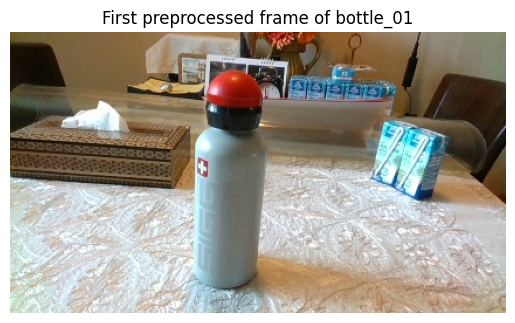

In [6]:
# Example usage
if __name__ == "__main__":
    # Assuming load_openloris_data is already implemented
    data_path = "."  # Path to the directory containing test.zip
    max_images = 2 # Limit to 5 images per object (the more image you load, the higher memory for processing is requried)
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)

    # Choose a factor, segment, and object to preprocess
    factor = 'illumination'
    segment = 'segment1'
    object_name = 'bottle_01'

    # Preprocess the data
    preprocessed_data = preprocess_for_dmd(dataset, factor, segment, object_name)

    # Print information about the preprocessed data
    print(f"Preprocessed data shape: {preprocessed_data.shape}")
    print(f"Preprocessed data type: {preprocessed_data.dtype}")
    print(f"Preprocessed data range: [{preprocessed_data.min()}, {preprocessed_data.max()}]")

    # Additional checks
    original_frames = dataset['test']['rgb'][factor][segment][object_name]
    assert preprocessed_data.shape[1] == len(original_frames), "Number of frames doesn't match"
    assert preprocessed_data.shape[0] == np.prod(original_frames[0].shape), "Number of features doesn't match"
    assert preprocessed_data.dtype == np.float64, "Data type should be float64"
    assert 0 <= preprocessed_data.min() and preprocessed_data.max() <= 1, "Data should be normalized to [0, 1]"

    print("All checks passed! Your implementation looks correct.")

    # Visualize the first preprocessed frame
    import matplotlib.pyplot as plt
    
    first_frame = preprocessed_data[:, 0].reshape(original_frames[0].shape)
    plt.imshow(first_frame)
    plt.title(f"First preprocessed frame of {object_name}")
    plt.axis('off')
    plt.show()

STEP 2: DMD Analysis Across Environmental Factors

In [7]:
import matplotlib.pyplot as plt
from scipy.linalg import svd

def analyze_and_plot_environmental_factor(data, factor, original_shape, r=2, plot=True):
    """
    Perform DMD analysis and plot eigenvalues and modes for a specific environmental factor.

    Parameters:
    data (np.array): Preprocessed data, shape (n_features, n_frames), dtype float64
        where n_features = height * width * 3 (for RGB channels)
        and n_frames is the number of frames
    factor (str): Environmental factor being analyzed. One of:
        'illumination': Changes in lighting conditions
        'occlusion': Partial blocking of objects
        'pixel': Changes in object size/resolution
        'clutter': Different background conditions
    original_shape (tuple): Original shape of a single RGB image (height, width, 3)
    r (int): Number of modes to compute and plot. Default is 2.

    Returns:
    tuple: (modes, eigenvalues, dynamics)
        modes (np.array): DMD modes, shape (n_features, r), dtype complex128
        eigenvalues (np.array): DMD eigenvalues, shape (r,), dtype complex128
        dynamics (np.array): DMD mode dynamics, shape (r, n_frames-1), dtype complex128

    Visualization:
    The function creates a figure with two subplots:
    1. DMD Eigenvalues Plot (left)
    2. First DMD Mode Plot (right)
    """
    # Step 1: Perform SVD on the data to prepare for DMD
    X1 = data[:, :-1]
    X2 = data[:, 1:]
    U, Sigma, Vh = svd(X1, full_matrices=False)
    U_r = U[:, :r]
    Sigma_r = np.diag(Sigma[:r])
    V_r = Vh.conj().T[:, :r]

    # Step 2: Compute the DMD matrix A_tilde
    A_tilde = U_r.conj().T @ X2 @ V_r @ np.linalg.inv(Sigma_r)
    
    # Step 3: Eigen decomposition of A_tilde to find eigenvalues and modes
    eigenvalues, W = np.linalg.eig(A_tilde)
    modes = U_r @ W  # DMD modes in the original data space
    dynamics = np.dot(np.diag(eigenvalues), V_r.T)  # Mode dynamics

    # Step 4: Visualization
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Eigenvalues plot
        ax = axes[0]
        unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
        ax.add_artist(unit_circle)
        ax.scatter(eigenvalues.real, eigenvalues.imag, color='b', marker='o')
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax.axvline(1, color='black', linestyle='--', linewidth=0.5)
        ax.set_xlabel('Real')
        ax.set_ylabel('Imaginary')
        ax.set_title(f'{factor.capitalize()} - DMD Eigenvalues')

        # First DMD mode plot
        ax = axes[1]
        first_mode = np.abs(modes[:, 0]).reshape(original_shape)
        first_mode_normalized = (first_mode - first_mode.min()) / (first_mode.max() - first_mode.min())
        im = ax.imshow(first_mode_normalized, cmap='viridis')
        fig.colorbar(im, ax=ax)
        ax.set_title(f'{factor.capitalize()} - First DMD Mode')
        ax.axis('off')

        plt.tight_layout()
        plt.show()

    return modes, eigenvalues, dynamics

Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

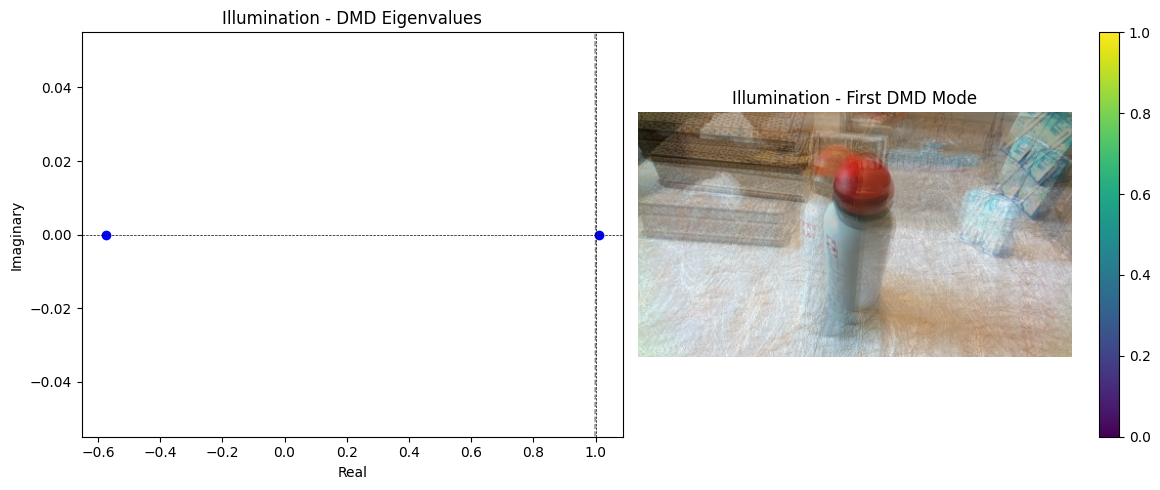

Number of modes: 2
Number of time steps: 4
Eigenvalue range: [0.574, 1.010]

Analyzing occlusion factor...


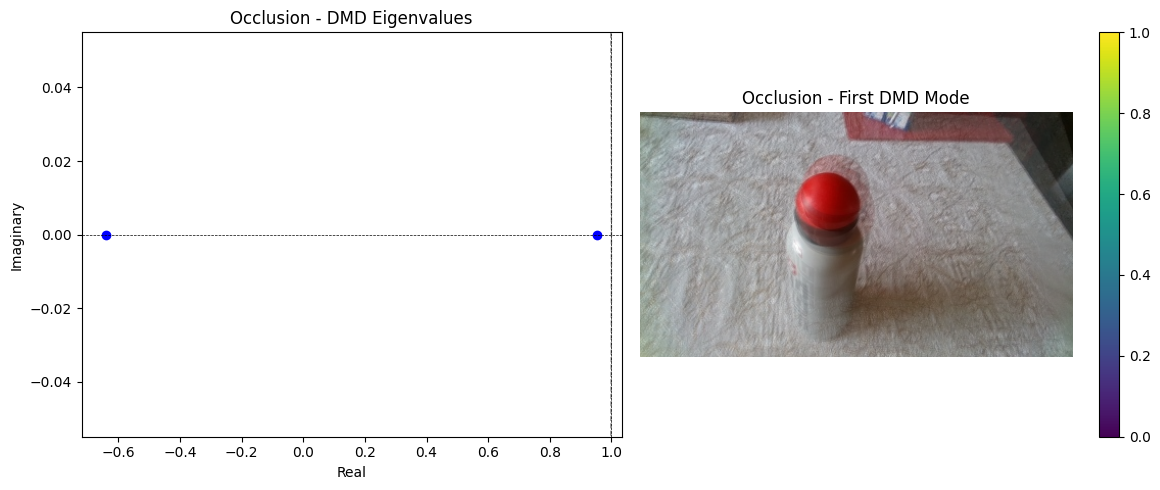

Number of modes: 2
Number of time steps: 4
Eigenvalue range: [0.640, 0.954]

Analyzing pixel factor...


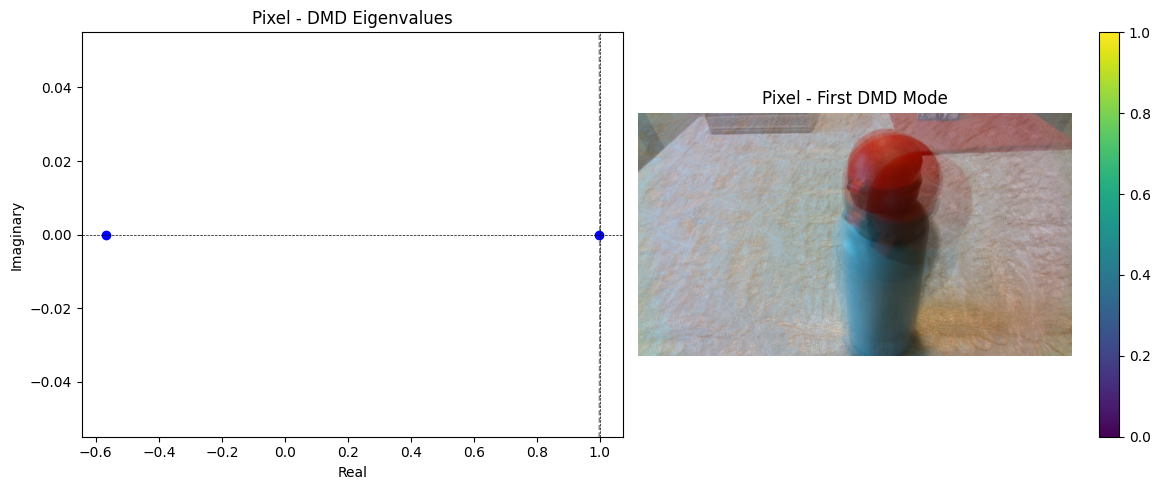

Number of modes: 2
Number of time steps: 4
Eigenvalue range: [0.567, 0.996]

Analyzing clutter factor...


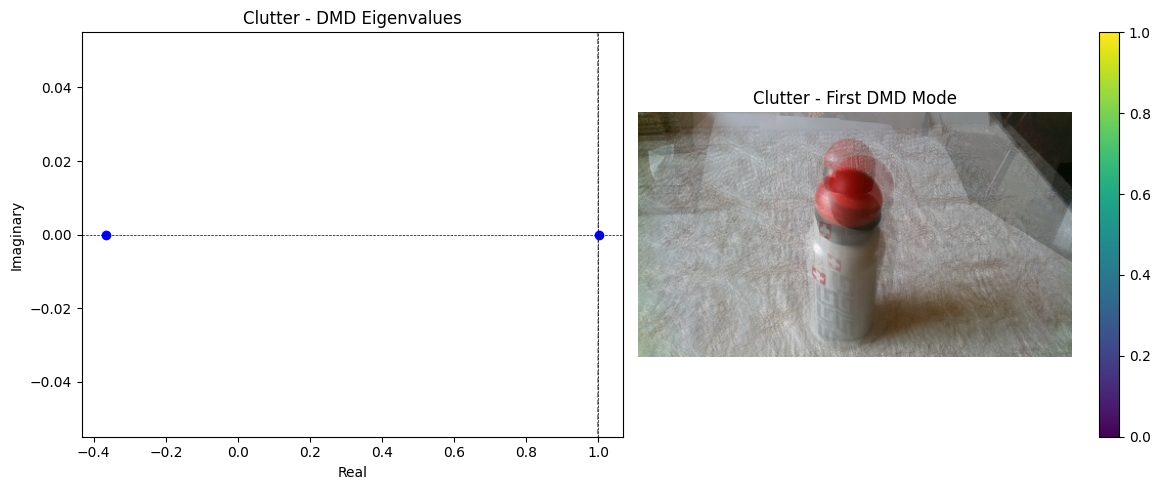

Number of modes: 2
Number of time steps: 4
Eigenvalue range: [0.365, 1.001]


In [8]:
# Example usage
if __name__ == "__main__":
    # Load and preprocess the data
    data_path = "."
    max_images = 5
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)
    
    # Analyze each environmental factor
    factors = ['illumination', 'occlusion', 'pixel', 'clutter']
    segment = 'segment1'
    object_name = 'bottle_01'
    n_modes = 2
    
    for factor in factors:
        if (factor in dataset['test']['rgb'] and 
            segment in dataset['test']['rgb'][factor] and 
            object_name in dataset['test']['rgb'][factor][segment]):
            
            print(f"\nAnalyzing {factor} factor...")
            
            # Get the original shape
            original_shape = dataset['test']['rgb'][factor][segment][object_name][0].shape
            
            # Preprocess the data
            preprocessed_data = preprocess_for_dmd(dataset, factor, segment, object_name)
            
            # Perform DMD analysis and plot eigenvalues and modes
            modes, eigenvalues, dynamics = analyze_and_plot_environmental_factor(
                preprocessed_data, 
                factor, 
                original_shape, 
                r=n_modes
            )
            
            print(f"Number of modes: {modes.shape[1]}")
            print(f"Number of time steps: {dynamics.shape[1]}")
            print(f"Eigenvalue range: [{np.min(np.abs(eigenvalues)):.3f}, {np.max(np.abs(eigenvalues)):.3f}]")

In [9]:
def plot_environmental_factor_dynamics(dynamics, eigenvalues, factor, r=2):
    """
    Plot the dynamics of DMD modes for a specific environmental factor.

    Parameters:
    dynamics (np.array): DMD mode dynamics, shape (r, n_frames-1), dtype complex128
        where r is the number of modes and n_frames is the number of frames
    eigenvalues (np.array): DMD eigenvalues, shape (r,), dtype complex128
    factor (str): Environmental factor being analyzed. One of:
        'illumination': Changes in lighting conditions
        'occlusion': Partial blocking of objects
        'pixel': Changes in object size/resolution
        'clutter': Different background conditions
    r (int): Number of modes to plot. Default is 2.

    Returns:
    None: The function displays the plots but does not return any value

    Visualization:
    The function creates a figure with two subplots:
    1. Mode Dynamics Plot (left)
    2. Eigenvalue Plot (right)
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Mode Dynamics Plot
    ax = axes[0]
    time_steps = np.arange(dynamics.shape[1])
    for i in range(r):
        ax.plot(time_steps, np.abs(dynamics[i, :]), label=f'Mode {i+1}')
    ax.set_yscale('log')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Mode Magnitude (log scale)')
    ax.set_title(f'{factor.capitalize()} - Mode Dynamics')
    ax.legend()

    # Eigenvalue Plot with Unit Circle
    ax = axes[1]
    unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(unit_circle)
    ax.scatter(eigenvalues.real, eigenvalues.imag, color='b', marker='o')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title(f'{factor.capitalize()} - Eigenvalues with Unit Circle')

    plt.tight_layout()
    plt.show()

Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

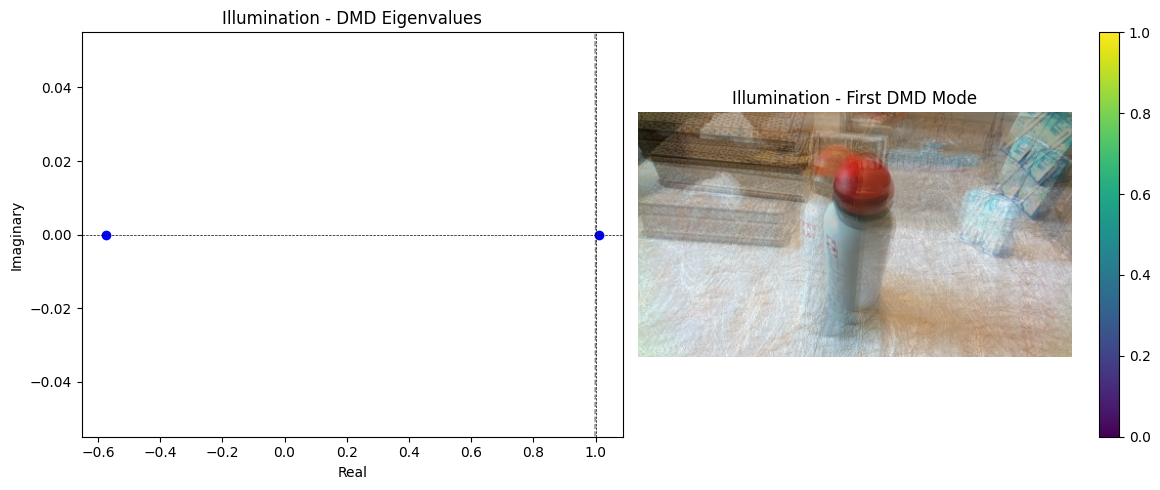

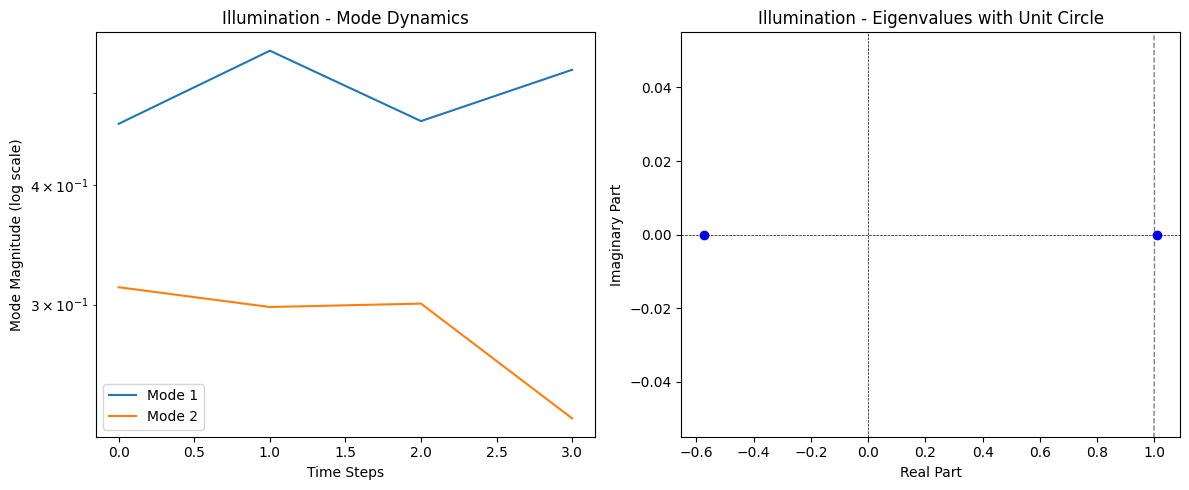

Number of modes plotted: 2
Number of time steps: 4
Eigenvalue magnitudes: [1.00996563 0.57367731]

Analyzing dynamics for occlusion factor...


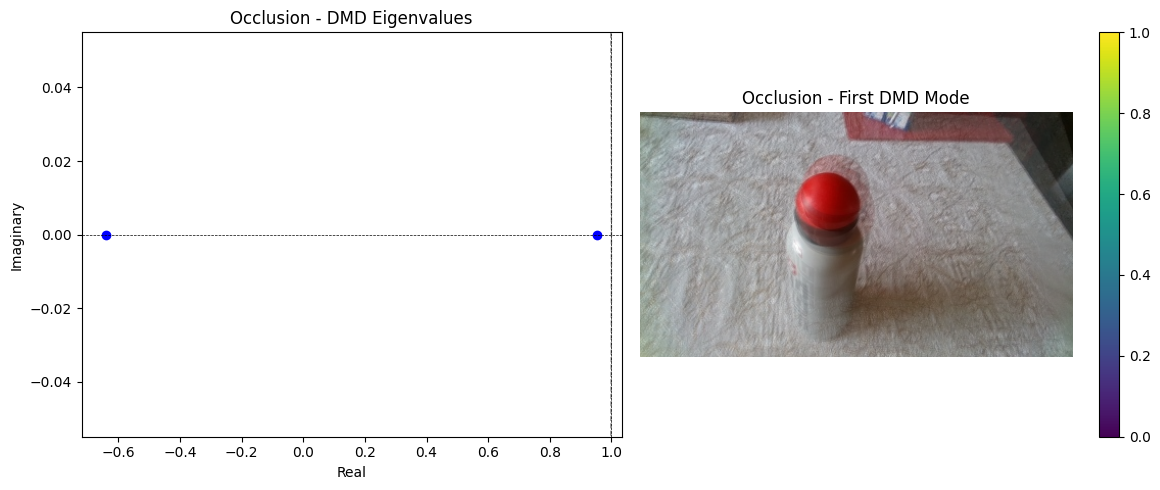

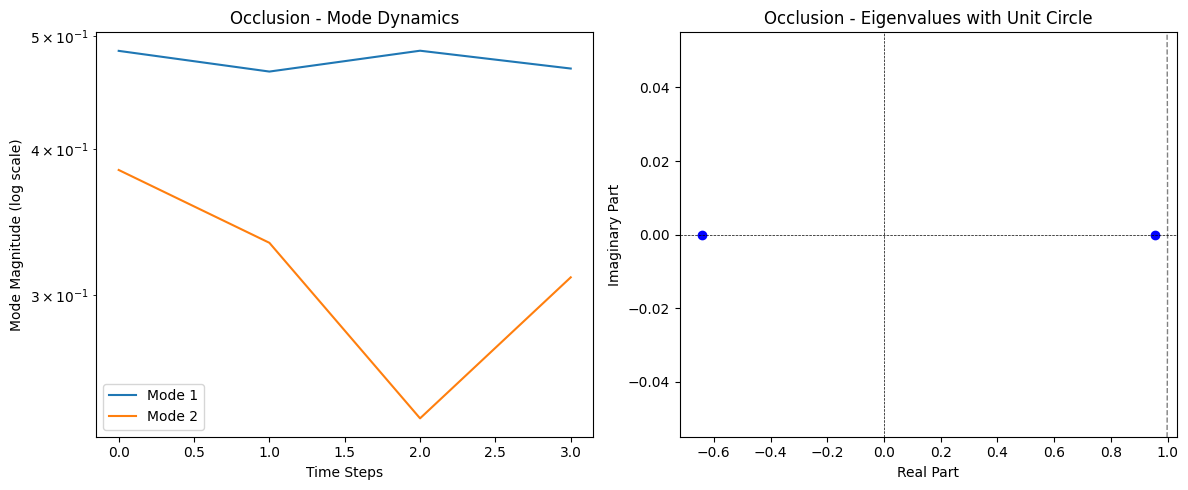

Number of modes plotted: 2
Number of time steps: 4
Eigenvalue magnitudes: [0.95398659 0.63996651]

Analyzing dynamics for pixel factor...


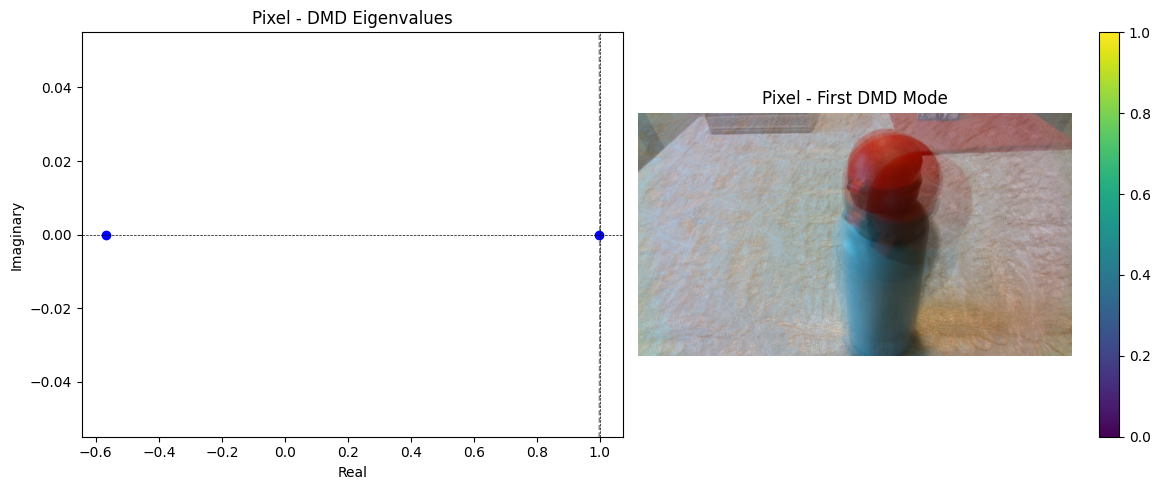

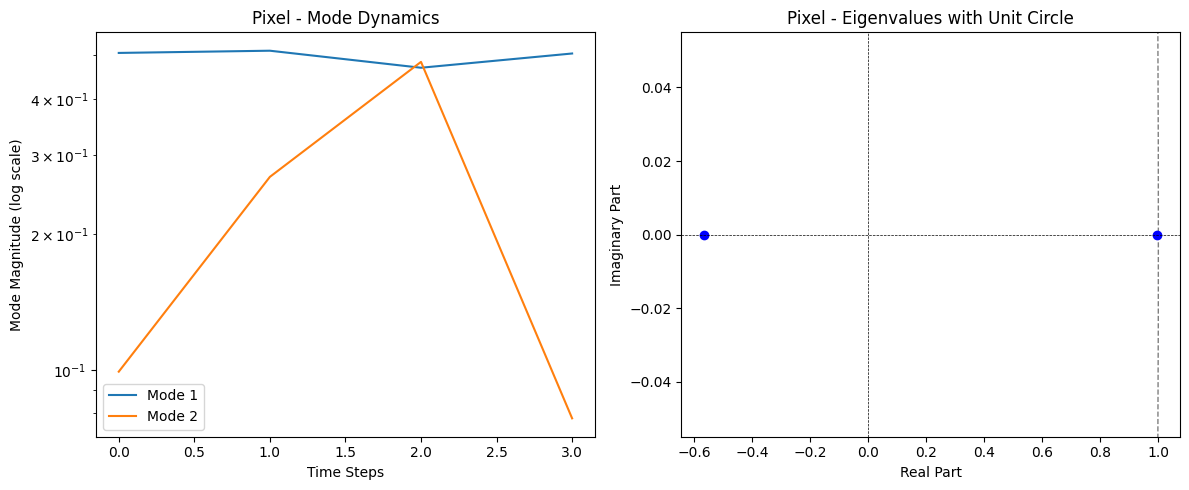

Number of modes plotted: 2
Number of time steps: 4
Eigenvalue magnitudes: [0.99647012 0.56711401]

Analyzing dynamics for clutter factor...


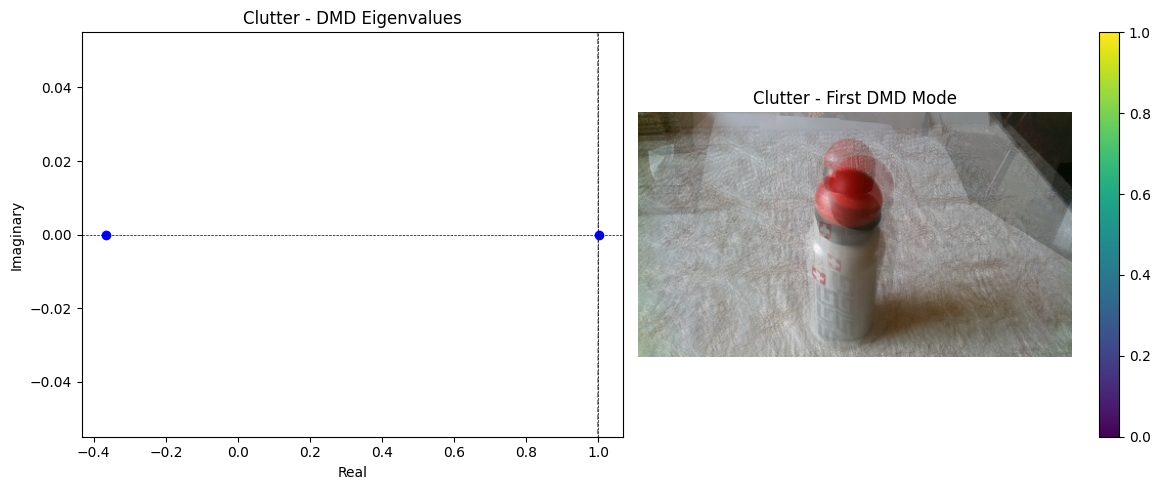

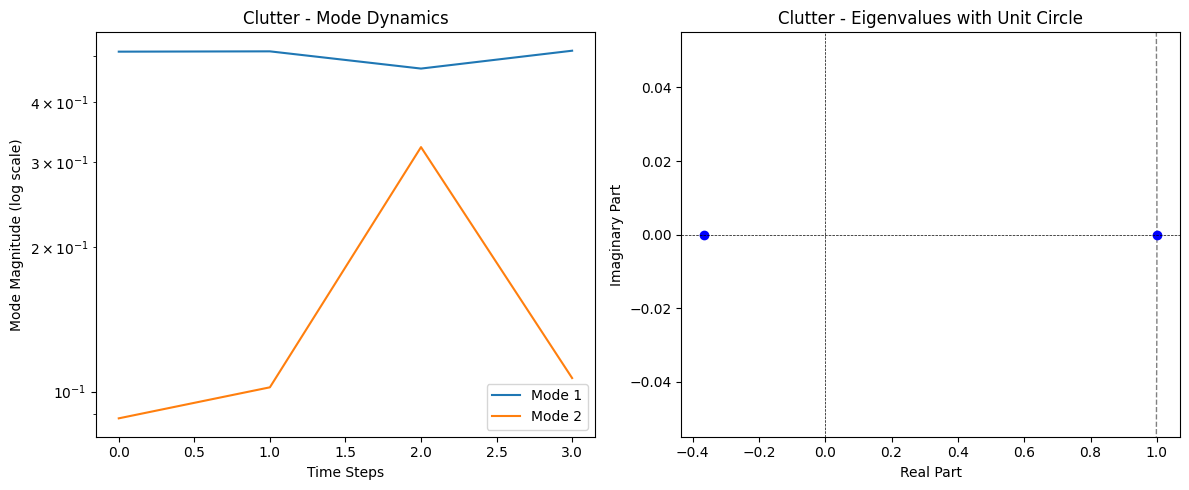

Number of modes plotted: 2
Number of time steps: 4
Eigenvalue magnitudes: [1.00121204 0.36548192]


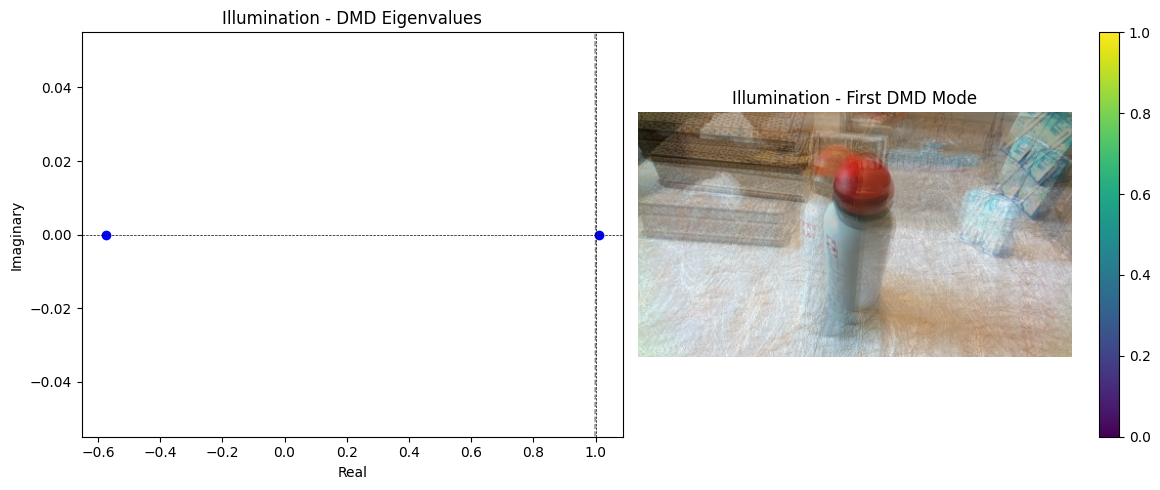

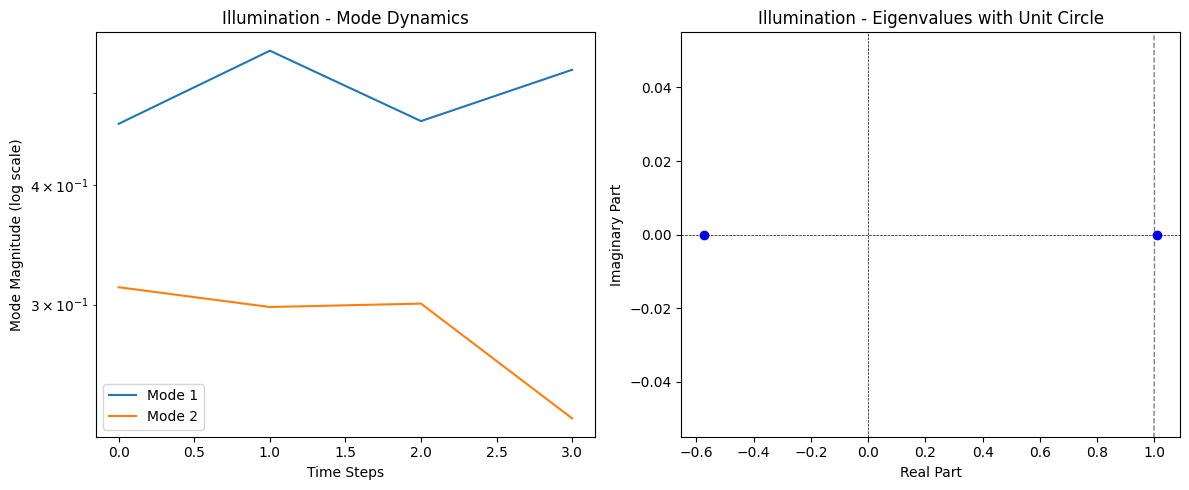


All checks passed!


In [10]:
# Example usage
if __name__ == "__main__":
    # Load and preprocess the data
    data_path = "."
    max_images = 5  # Need multiple images for meaningful dynamics
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)
    
    # Analysis parameters
    factors = ['illumination', 'occlusion', 'pixel', 'clutter']
    segment = 'segment1'
    object_name = 'bottle_01'
    n_modes = 2
    
    for factor in factors:
        if (factor in dataset['test']['rgb'] and 
            segment in dataset['test']['rgb'][factor] and 
            object_name in dataset['test']['rgb'][factor][segment]):
            
            print(f"\nAnalyzing dynamics for {factor} factor...")
            
            # Get the original shape and preprocess data
            original_shape = dataset['test']['rgb'][factor][segment][object_name][0].shape
            preprocessed_data = preprocess_for_dmd(dataset, factor, segment, object_name)
            
            # Perform DMD analysis
            modes, eigenvalues, dynamics = analyze_and_plot_environmental_factor(
                preprocessed_data, 
                factor, 
                original_shape, 
                r=n_modes
            )
            
            # Plot the dynamics
            plot_environmental_factor_dynamics(dynamics, eigenvalues, factor, r=n_modes)
            
            print(f"Number of modes plotted: {min(n_modes, dynamics.shape[0])}")
            print(f"Number of time steps: {dynamics.shape[1]}")
            print(f"Eigenvalue magnitudes: {np.abs(eigenvalues)}")

    # Verification
    test_factor = factors[0]
    test_data = preprocess_for_dmd(dataset, test_factor, segment, object_name)
    test_modes, test_eigenvalues, test_dynamics = analyze_and_plot_environmental_factor(
        test_data, test_factor, original_shape, r=n_modes
    )
    
    # Plot dynamics for verification
    plot_environmental_factor_dynamics(test_dynamics, test_eigenvalues, test_factor, r=n_modes)
    
    # Basic checks
    assert test_dynamics.shape[0] == n_modes, "Number of modes doesn't match"
    assert test_dynamics.shape[1] == test_data.shape[1]-1, "Number of time steps doesn't match"
    print("\nAll checks passed!")

STEP 3: Comparitive Analysis Across Environmental Factors

In [53]:
def compare_environmental_factors(dataset, object_name, factors=['illumination', 'occlusion', 'pixel', 'clutter'], segment='segment1', r=2):
    """
    Compare DMD analysis results across different environmental factors for the same object.
    
    - This version accounts for the fact that object_name is buried deeper in the dataset.
    
    Returns the comparison results in a dictionary.
    """
    # Ensure 'test' is a key in the dataset, where objects are stored
    if 'test' not in dataset:
        print("'test' key not found in dataset.")
        return {}

    # Initialize the results dictionary to store comparison data
    results = {}

    # Loop over each environmental factor
    for factor in factors:
        # Ensure the factor exists in the dataset
        if factor not in dataset['test']['rgb']:
            print(f"Factor {factor} not found in dataset.")
            continue
        
        # Check if the segment is available in the dataset for the factor
        if segment not in dataset['test']['rgb'][factor]:
            print(f"Segment {segment} not found for factor {factor}.")
            continue

        # Access object data for the given factor, segment, and object_name
        if object_name not in dataset['test']['rgb'][factor][segment]:
            print(f"Object {object_name} not found in factor {factor}, segment {segment}.")
            continue

        object_data = dataset['test']['rgb'][factor][segment][object_name]

        # Store object data as a dictionary (if it's not already a dictionary)
        if isinstance(object_data, np.ndarray):
            # If object_data is an ndarray (e.g., image array), we can create a dummy dictionary with this data
            object_data_dict = {
                'frames': object_data,  # Assuming object_data is the frames (images)
                'modes': None,  # Placeholder, add real data if available
                'eigenvalues': None,  # Placeholder, add real data if available
                'dynamics': None  # Placeholder, add real data if available
            }
        else:
            # If object_data is already a dictionary, we can use it directly
            object_data_dict = object_data

        # Now that we have the object data in dictionary form, we can proceed with the comparison
        # Check the data structure
        print(f"Object data for {object_name}: {object_data_dict}")

        # Process the dictionary data for analysis
        if 'frames' in object_data_dict:
            frames = object_data_dict['frames']  # Frames for DMD (or other analysis)
            # Example of extracting features from frames
            eigenvalue_magnitudes = np.abs(frames)  # Dummy processing
            mode_energies = np.sum(np.abs(frames), axis=0)  # Dummy example
            temporal_variation = np.std(frames, axis=1)  # Dummy example

            # Store results for each factor
            results[factor] = {
                'eigenvalue_magnitudes': eigenvalue_magnitudes,
                'mode_energies': mode_energies,
                'temporal_variation': temporal_variation
            }

    return results



In [54]:
# Example usage
if __name__ == "__main__":
    # Load data
    data_path = "."
    max_images = 4
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)
    
    # Choose an object to analyze
    object_name = 'bottle_01'
    
    # Compare environmental factors
    results = compare_environmental_factors(dataset, object_name)
    
    # Print summary statistics
    print("\nComparison Summary:")
    for factor, metrics in results.items():
        print(f"\n{factor.capitalize()}:")
        print(f"  Average eigenvalue magnitude: {np.mean(metrics['eigenvalue_magnitudes']):.3f}")
        print(f"  Total mode energy: {np.sum(metrics['mode_energies']):.3f}")
        print(f"  Average temporal variation: {np.mean(metrics['temporal_variation']):.3f}")

Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

STEP 4: Reconstruction Quality Analysis

In [62]:
def analyze_reconstruction_quality(original_data, modes, dynamics, original_shape, r=2):
    """
    Analyze how well DMD reconstructs the original data.

    Parameters:
    -----------
    original_data (np.array): Original video sequence, shape (n_features, n_frames)
        where n_features = height * width * 3 (for RGB channels)
        and n_frames is the number of frames
    modes (np.array): DMD modes, shape (n_features, n_modes)
        Each column represents a spatial pattern
    dynamics (np.array): Mode dynamics, shape (n_modes, n_frames-1)
        Each row shows how a mode evolves over time
    original_shape (tuple): Shape of original frames (height, width, channels)
        Used to reshape flattened data back to image format
    r (int): Number of modes to use for reconstruction
        Smaller r: simpler reconstruction, might miss details
        Larger r: more detailed reconstruction, might include noise

    Returns:
    --------
    dict: Quality metrics and reconstructed data
        'reconstruction': np.array, shape (n_features, n_frames-1)
            The reconstructed video sequence using r modes
            Can be reshaped to (height, width, 3) for each frame
        
        'error': np.array, shape (n_frames-1,)
            Euclidean norm of difference between original and reconstruction
            for each frame. Higher values indicate worse reconstruction
        
        'relative_error': np.array, shape (n_frames-1,)
            Error normalized by the norm of original data
            Values between 0 and 1:
            - Close to 0: excellent reconstruction
            - Close to 1: poor reconstruction

    Visualization:
    -------------
    The function creates a figure with two subplots:
    1. Reconstruction Error Map (left):
       - Shows spatial distribution of errors in first frame
       - Brighter areas indicate larger reconstruction errors
       - Darker areas indicate better reconstruction
       - Colorbar shows error magnitude
    
    2. Error Over Time (right):
       - Shows how reconstruction quality varies across frames
       - X-axis: Frame number
       - Y-axis: Relative error magnitude
       - Helps identify frames with poor reconstruction

    Example interpretation:
    ----------------------
    - Low average relative error (<0.1): Good reconstruction
    - High error in specific regions: Local features not well captured
    - Increasing error over time: Temporal dynamics not well captured
    - Uniform error map: Consistent reconstruction quality
    - Patchy error map: Some features harder to reconstruct

    Note:
    -----
    - The first frame is used for error map visualization
    - Reconstruction starts from second frame (due to DMD algorithm)
    - Error metrics use Euclidean norm (root sum of squared differences)
    """
    
    # Ensure dynamics and modes are not None
    if modes is None or dynamics is None:
        print("Error: DMD modes or dynamics are None.")
        return None
    
    # Ensure original data is in the correct format
    n_features, n_frames = original_data.shape
    if n_frames != dynamics.shape[1] + 1:
        print(f"Error: Frame mismatch. Dynamics have {dynamics.shape[1]} frames, but original data has {n_frames}.")
        return None

    # Reconstruct the data using the first 'r' modes and dynamics
    reconstruction = np.dot(modes[:, :r], dynamics[:r, :])  # Shape (n_features, n_frames-1)
    
    # Calculate reconstruction error using Euclidean norm (for vectors)
    error = np.linalg.norm(original_data[:, 1:] - reconstruction, axis=0)  # Error per frame (Euclidean norm)
    relative_error = error / np.linalg.norm(original_data[:, 1:], axis=0)  # Relative error per frame
    
    # Reshape the reconstruction and original data for visualization
    reconstruction_reshaped = reconstruction.reshape((n_frames-1, *original_shape))  # Reshape back to frames
    original_reshaped = original_data[:, 1:].reshape((n_frames-1, *original_shape))  # Reshape back to frames
    
    # Visualization of the reconstruction error map (first frame)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Error map (spatial distribution)
    error_map = np.linalg.norm(original_reshaped[0] - reconstruction_reshaped[0], axis=2)
    im1 = ax1.imshow(error_map, cmap='hot')
    ax1.set_title("Reconstruction Error Map (First Frame)")
    fig.colorbar(im1, ax=ax1)
    
    # Error over time (temporal variation)
    ax2.plot(np.arange(1, n_frames), relative_error)
    ax2.set_title("Relative Error Over Time")
    ax2.set_xlabel("Frame number")
    ax2.set_ylabel("Relative Error")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'reconstruction': reconstruction,
        'error': error,
        'relative_error': relative_error
    }

Error loading image __MACOSX/test/illumination/segment4/._plug_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_04: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_04' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._bowl_03: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._bowl_03' mode='r' compress_type=deflate>
Error loading image __MACOSX/test/illumination/segment4/._plug_02: cannot identify image file <zipfile.ZipExtFile name='__MACOSX/test/illumination/segment4/._plug_02' mode='r' compress_type=deflate>
Error

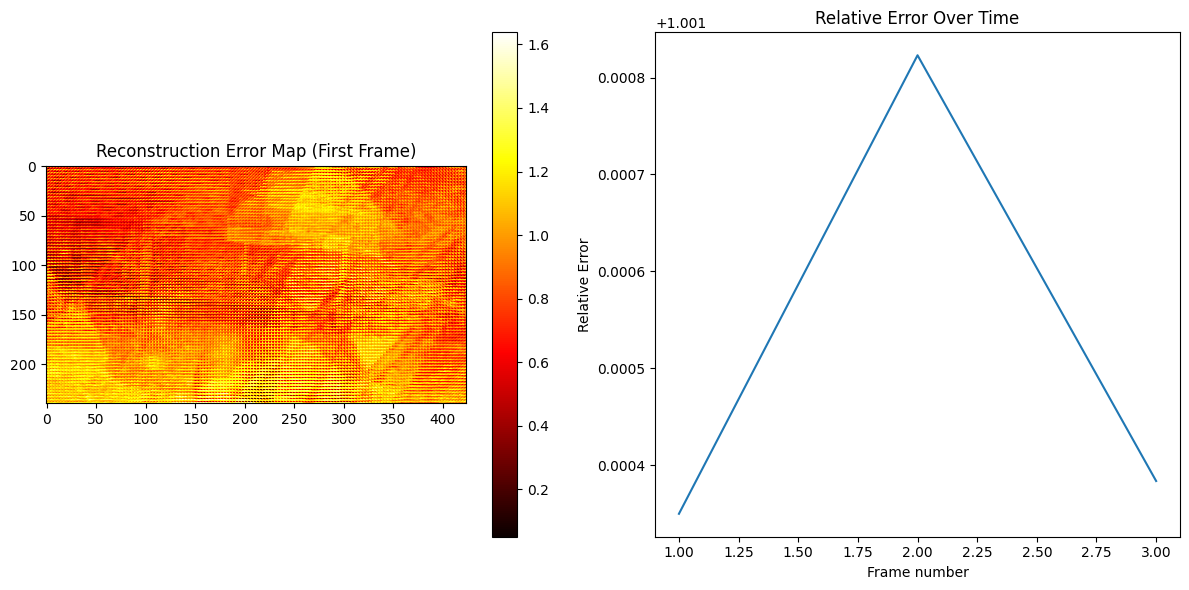


Reconstruction Quality Summary:
Average relative error: 1.002
Maximum relative error: 1.002


In [63]:
# Example usage

if __name__ == "__main__":
    # Load data
    data_path = "."
    max_images = 4
    dataset = load_openloris_data(data_path, max_images_per_object=max_images)
    
    # Choose a sequence to analyze
    factor = 'illumination'
    segment = 'segment1'
    object_name = 'bottle_01'
    
    # Get original shape
    original_shape = dataset['test']['rgb'][factor][segment][object_name][0].shape
    
    # Preprocess data
    preprocessed_data = preprocess_for_dmd(dataset, factor, segment, object_name)
    
    # Perform DMD analysis
    modes, _, dynamics = analyze_and_plot_environmental_factor(
        preprocessed_data, 
        factor, 
        original_shape,
        r=5,
        plot=False
    )
    
    # Analyze reconstruction quality
    results = analyze_reconstruction_quality(
        preprocessed_data, 
        modes, 
        dynamics, 
        original_shape,
        r=2
    )
    
    # Print summary statistics
    print("\nReconstruction Quality Summary:")
    print(f"Average relative error: {np.mean(results['relative_error']):.3f}")
    print(f"Maximum relative error: {np.max(results['relative_error']):.3f}")